In [16]:
!pip install transformers torch nltk rouge-score bert-score matplotlib seaborn pandas numpy
!pip install sentencepiece protobuf


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time
import warnings
warnings.filterwarnings('ignore')

In [18]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [19]:
try:
    import nltk
    from nltk.tokenize import sent_tokenize, word_tokenize
    from nltk.corpus import stopwords
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    NLTK_AVAILABLE = True
except:
    NLTK_AVAILABLE = False

# Transformer models
try:
    from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
    TRANSFORMERS_AVAILABLE = True
except:
    TRANSFORMERS_AVAILABLE = False

# Evaluation metrics
try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
except:
    ROUGE_AVAILABLE = False

In [20]:
class TextSummarizer:
    """
    A comprehensive text summarization system with multiple algorithms
    """
    
    def __init__(self):
        self.results = {}
        if TRANSFORMERS_AVAILABLE:
            print("Loading BART model for abstractive summarization...")
            self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
            print("✓ Model loaded successfully")
        
    def extractive_tfidf(self, text, num_sentences=3):
        """
        Extractive summarization using TF-IDF scoring
        """
        sentences = sent_tokenize(text) if NLTK_AVAILABLE else re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if len(s.strip()) > 10]
        
        if len(sentences) <= num_sentences:
            return ' '.join(sentences)
        
        # Calculate word frequencies (TF)
        words = re.findall(r'\w+', text.lower())
        stop_words = set(stopwords.words('english')) if NLTK_AVAILABLE else {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'is', 'was'
        }
        
        word_freq = Counter([w for w in words if w not in stop_words])
        max_freq = max(word_freq.values()) if word_freq else 1
        
        # Normalize frequencies
        for word in word_freq:
            word_freq[word] = word_freq[word] / max_freq
        
        # Score sentences
        sentence_scores = {}
        for i, sentence in enumerate(sentences):
            score = 0
            words_in_sent = re.findall(r'\w+', sentence.lower())
            for word in words_in_sent:
                if word in word_freq:
                    score += word_freq[word]
            sentence_scores[i] = score / len(words_in_sent) if words_in_sent else 0
        
        # Select top sentences
        top_indices = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:num_sentences]
        top_indices = sorted(top_indices)  # Maintain order
        
        return ' '.join([sentences[i] for i in top_indices])
    
    def extractive_textrank(self, text, num_sentences=3):
        """
        Extractive summarization using TextRank algorithm (simplified)
        """
        sentences = sent_tokenize(text) if NLTK_AVAILABLE else re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if len(s.strip()) > 10]
        
        if len(sentences) <= num_sentences:
            return ' '.join(sentences)
        
        # Build similarity matrix
        n = len(sentences)
        similarity_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    words_i = set(re.findall(r'\w+', sentences[i].lower()))
                    words_j = set(re.findall(r'\w+', sentences[j].lower()))
                    
                    if len(words_i | words_j) > 0:
                        similarity_matrix[i][j] = len(words_i & words_j) / len(words_i | words_j)
        
        # Calculate scores using PageRank-like algorithm
        scores = np.ones(n)
        for _ in range(10):  # Iterations
            new_scores = np.zeros(n)
            for i in range(n):
                new_scores[i] = 0.15 + 0.85 * np.sum(similarity_matrix[:, i] * scores) / (np.sum(similarity_matrix[:, i]) + 1e-8)
            scores = new_scores
        
        # Select top sentences
        top_indices = np.argsort(scores)[-num_sentences:]
        top_indices = sorted(top_indices)
        
        return ' '.join([sentences[i] for i in top_indices])
    
    def abstractive_transformer(self, text, max_length=150, min_length=40):
        """
        Abstractive summarization using BART transformer
        """
        if not TRANSFORMERS_AVAILABLE:
            return "Transformers library not available"
        
        try:
            # Handle long texts by chunking
            max_input = 1024
            if len(text.split()) > max_input:
                text = ' '.join(text.split()[:max_input])
            
            summary = self.summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
            return summary[0]['summary_text']
        except Exception as e:
            return f"Error: {str(e)}"


In [21]:
class SummaryEvaluator:
    """
    Evaluate summary quality using multiple metrics
    """
    
    def __init__(self):
        if ROUGE_AVAILABLE:
            self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    def calculate_rouge(self, reference, generated):
        """
        Calculate ROUGE scores (industry standard for summarization)
        """
        if not ROUGE_AVAILABLE:
            return None
        
        scores = self.scorer.score(reference, generated)
        return {
            'ROUGE-1': round(scores['rouge1'].fmeasure, 4),
            'ROUGE-2': round(scores['rouge2'].fmeasure, 4),
            'ROUGE-L': round(scores['rougeL'].fmeasure, 4)
        }
    
    def calculate_compression_ratio(self, original, summary):
        """
        Calculate how much the text was compressed
        """
        orig_words = len(original.split())
        summ_words = len(summary.split())
        return round((1 - summ_words/orig_words) * 100, 2)
    
    def calculate_readability(self, text):
        """
        Flesch Reading Ease score
        """
        sentences = len(re.split(r'[.!?]+', text))
        words = len(text.split())
        syllables = sum([self._count_syllables(word) for word in text.split()])
        
        if sentences == 0 or words == 0:
            return 0
        
        score = 206.835 - 1.015 * (words/sentences) - 84.6 * (syllables/words)
        return round(max(0, min(100, score)), 2)
    
    def _count_syllables(self, word):
        """Helper to count syllables"""
        word = word.lower()
        count = 0
        vowels = 'aeiouy'
        if word[0] in vowels:
            count += 1
        for i in range(1, len(word)):
            if word[i] in vowels and word[i-1] not in vowels:
                count += 1
        if word.endswith('e'):
            count -= 1
        if count == 0:
            count += 1
        return count
    
    def calculate_information_retention(self, original, summary):
        """
        Calculate what percentage of key information is retained
        """
        # Extract key terms (nouns, verbs) from original
        orig_words = set(re.findall(r'\b[a-z]{4,}\b', original.lower()))
        summ_words = set(re.findall(r'\b[a-z]{4,}\b', summary.lower()))
        
        if not orig_words:
            return 0
        
        retained = len(orig_words & summ_words)
        return round((retained / len(orig_words)) * 100, 2)


In [22]:
def benchmark_summarization(text, reference_summary=None):
    """
    Comprehensive benchmarking of all summarization methods
    """
    summarizer = TextSummarizer()
    evaluator = SummaryEvaluator()
    
    results = []
    
    methods = [
        ('TF-IDF Extractive', lambda t: summarizer.extractive_tfidf(t, 3)),
        ('TextRank Extractive', lambda t: summarizer.extractive_textrank(t, 3)),
    ]
    
    if TRANSFORMERS_AVAILABLE:
        methods.append(('BART Abstractive', lambda t: summarizer.abstractive_transformer(t)))
    
    print("=" * 80)
    print("SUMMARIZATION BENCHMARK RESULTS")
    print("=" * 80)
    
    for method_name, method_func in methods:
        print(f"\n📊 Testing {method_name}...")
        
        start_time = time.time()
        summary = method_func(text)
        execution_time = time.time() - start_time
        
        # Calculate metrics
        compression = evaluator.calculate_compression_ratio(text, summary)
        readability = evaluator.calculate_readability(summary)
        info_retention = evaluator.calculate_information_retention(text, summary)
        
        rouge_scores = None
        if reference_summary and ROUGE_AVAILABLE:
            rouge_scores = evaluator.calculate_rouge(reference_summary, summary)
        
        result = {
            'Method': method_name,
            'Summary': summary,
            'Compression (%)': compression,
            'Readability Score': readability,
            'Info Retention (%)': info_retention,
            'Execution Time (s)': round(execution_time, 3)
        }
        
        if rouge_scores:
            result.update(rouge_scores)
        
        results.append(result)
        
        # Print summary
        print(f"\n✓ {method_name} Summary:")
        print(f"  {summary[:200]}..." if len(summary) > 200 else f"  {summary}")
        print(f"\n  Compression: {compression}% | Readability: {readability} | Info Retention: {info_retention}%")
        if rouge_scores:
            print(f"  ROUGE-1: {rouge_scores['ROUGE-1']} | ROUGE-2: {rouge_scores['ROUGE-2']} | ROUGE-L: {rouge_scores['ROUGE-L']}")
    
    return pd.DataFrame(results)


In [23]:
def visualize_results(results_df):
    """
    Create comprehensive visualizations of the results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Summarization Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Compression Ratio
    ax1 = axes[0, 0]
    bars1 = ax1.bar(results_df['Method'], results_df['Compression (%)'], color='steelblue', alpha=0.8)
    ax1.set_title('Compression Ratio', fontweight='bold')
    ax1.set_ylabel('Compression (%)')
    ax1.set_ylim(0, 100)
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # 2. Readability Score
    ax2 = axes[0, 1]
    bars2 = ax2.bar(results_df['Method'], results_df['Readability Score'], color='coral', alpha=0.8)
    ax2.set_title('Readability Score (Higher = Easier to Read)', fontweight='bold')
    ax2.set_ylabel('Score')
    ax2.set_ylim(0, 100)
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # 3. Information Retention
    ax3 = axes[1, 0]
    bars3 = ax3.bar(results_df['Method'], results_df['Info Retention (%)'], color='seagreen', alpha=0.8)
    ax3.set_title('Information Retention', fontweight='bold')
    ax3.set_ylabel('Retention (%)')
    ax3.set_ylim(0, 100)
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # 4. ROUGE Scores (if available)
    ax4 = axes[1, 1]
    if 'ROUGE-1' in results_df.columns:
        x = np.arange(len(results_df['Method']))
        width = 0.25
        ax4.bar(x - width, results_df['ROUGE-1'], width, label='ROUGE-1', alpha=0.8)
        ax4.bar(x, results_df['ROUGE-2'], width, label='ROUGE-2', alpha=0.8)
        ax4.bar(x + width, results_df['ROUGE-L'], width, label='ROUGE-L', alpha=0.8)
        ax4.set_ylabel('Score')
        ax4.set_title('ROUGE Scores (Quality Metrics)', fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(results_df['Method'])
        ax4.legend()
        ax4.set_ylim(0, 1)
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=15, ha='right')
    else:
        ax4.text(0.5, 0.5, 'ROUGE scores require\nreference summary', 
                ha='center', va='center', fontsize=12, transform=ax4.transAxes)
        ax4.set_title('ROUGE Scores (Not Available)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


In [24]:
def create_performance_report(results_df):
    """
    Generate a professional performance report
    """
    print("\n" + "=" * 80)
    print("DETAILED PERFORMANCE REPORT")
    print("=" * 80)
    
    # Summary statistics
    print("\n📈 SUMMARY STATISTICS:")
    print(f"  Average Compression: {results_df['Compression (%)'].mean():.2f}%")
    print(f"  Average Readability: {results_df['Readability Score'].mean():.2f}")
    print(f"  Average Info Retention: {results_df['Info Retention (%)'].mean():.2f}%")
    print(f"  Average Execution Time: {results_df['Execution Time (s)'].mean():.3f}s")
    
    # Best performing method
    if 'ROUGE-1' in results_df.columns:
        best_method = results_df.loc[results_df['ROUGE-1'].idxmax(), 'Method']
        print(f"\n🏆 BEST OVERALL (by ROUGE-1): {best_method}")
    
    # Detailed comparison table
    print("\n📊 DETAILED COMPARISON:")
    display_cols = ['Method', 'Compression (%)', 'Readability Score', 
                   'Info Retention (%)', 'Execution Time (s)']
    if 'ROUGE-1' in results_df.columns:
        display_cols.extend(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    
    print(results_df[display_cols].to_string(index=False))
    print("\n" + "=" * 80)


🚀 Starting Comprehensive Summarization Analysis...
SUMMARIZATION BENCHMARK RESULTS

📊 Testing TF-IDF Extractive...

✓ TF-IDF Extractive Summary:
  Global temperatures have risen by approximately 1.1 degrees Celsius since the pre-industrial era. The Paris Agreement, signed
by nearly 200 countries, aims to limit global warming to well below 2 degr...

  Compression: 71.43% | Readability: 28.71 | Info Retention: 30.7%
  ROUGE-1: 0.4444 | ROUGE-2: 0.1887 | ROUGE-L: 0.3519

📊 Testing TextRank Extractive...

✓ TextRank Extractive Summary:
  The primary cause of this warming is the emission of greenhouse gases, particularly carbon dioxide,
from human activities such as burning fossil fuels and deforestation. Governments worldwide are work...

  Compression: 64.29% | Readability: 15.94 | Info Retention: 35.96%
  ROUGE-1: 0.25 | ROUGE-2: 0.0339 | ROUGE-L: 0.1667


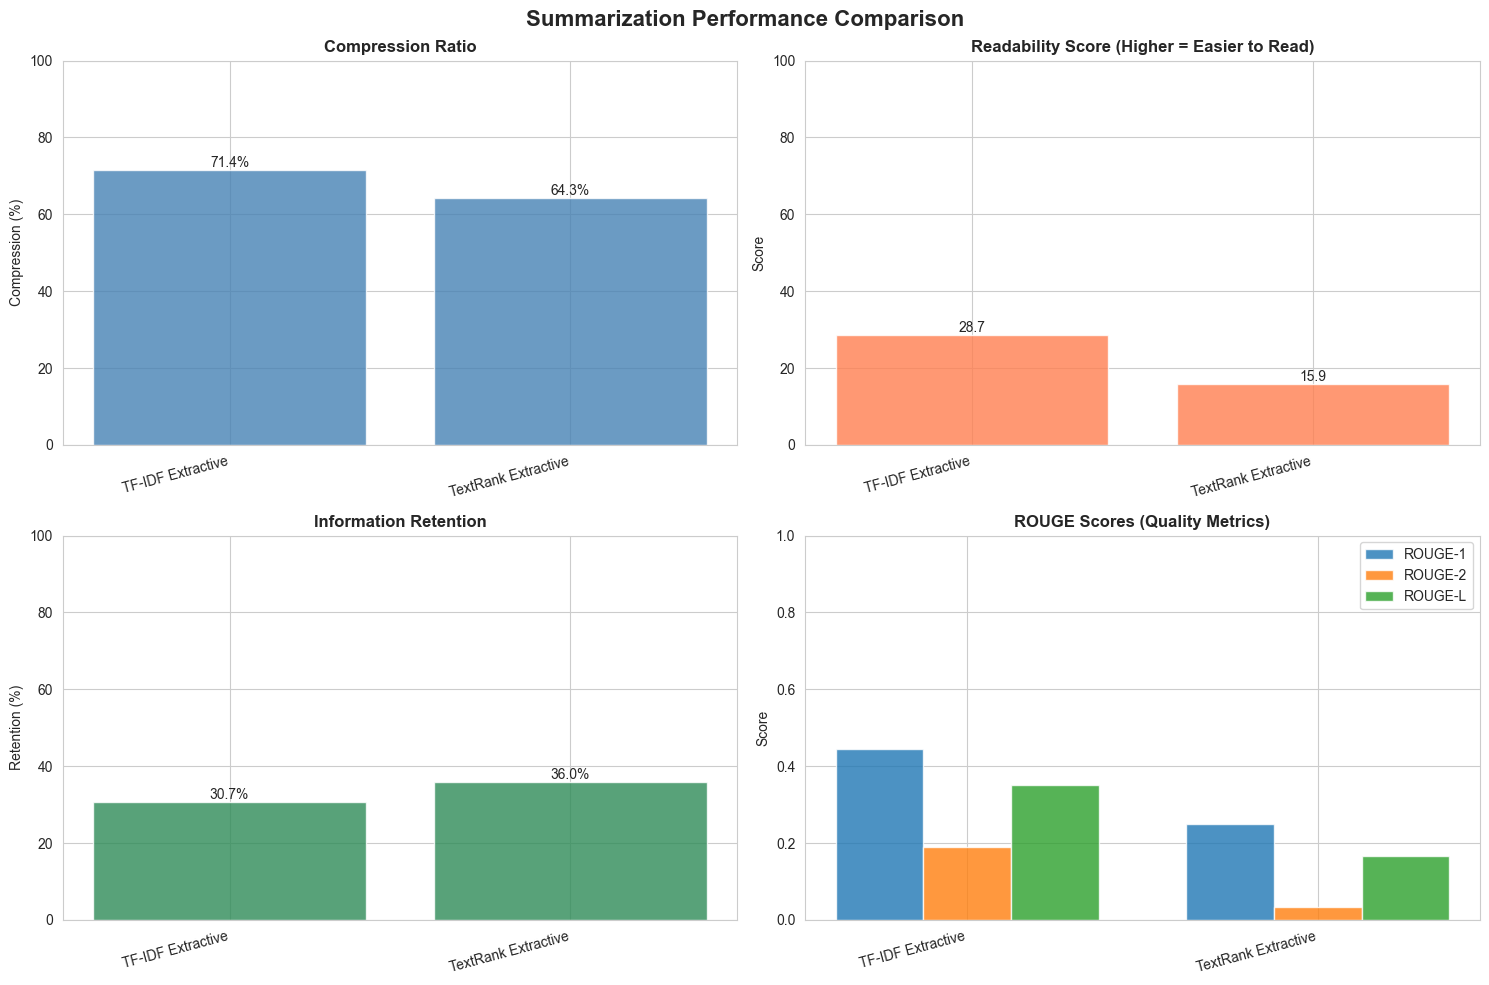


DETAILED PERFORMANCE REPORT

📈 SUMMARY STATISTICS:
  Average Compression: 67.86%
  Average Readability: 22.32
  Average Info Retention: 33.33%
  Average Execution Time: 0.003s

🏆 BEST OVERALL (by ROUGE-1): TF-IDF Extractive

📊 DETAILED COMPARISON:
             Method  Compression (%)  Readability Score  Info Retention (%)  Execution Time (s)  ROUGE-1  ROUGE-2  ROUGE-L
  TF-IDF Extractive            71.43              28.71               30.70               0.002   0.4444   0.1887   0.3519
TextRank Extractive            64.29              15.94               35.96               0.003   0.2500   0.0339   0.1667


💾 Results exported to 'summarization_results.csv'

✅ ANALYSIS COMPLETE!


In [25]:
sample_transcription = """
Climate change represents one of the most pressing challenges of our time. 
Global temperatures have risen by approximately 1.1 degrees Celsius since the pre-industrial era.
The primary cause of this warming is the emission of greenhouse gases, particularly carbon dioxide,
from human activities such as burning fossil fuels and deforestation. The consequences are far-reaching
and include more frequent extreme weather events, rising sea levels, and disruptions to ecosystems.
Scientists warn that without immediate action, we risk crossing critical tipping points that could
lead to irreversible changes in our climate system. Governments worldwide are working to implement
policies to reduce emissions and transition to renewable energy sources. The Paris Agreement, signed
by nearly 200 countries, aims to limit global warming to well below 2 degrees Celsius. However,
current commitments fall short of what is needed to achieve this goal. Individual actions, such as
reducing energy consumption and supporting sustainable practices, also play a crucial role in addressing
climate change. The transition to a low-carbon economy presents both challenges and opportunities,
potentially creating millions of new jobs in renewable energy and green technology sectors.
"""

# Reference summary (for ROUGE calculation)
reference_summary = """
Climate change, driven by greenhouse gas emissions from human activities, has increased global temperatures
by 1.1°C since pre-industrial times. This leads to extreme weather, rising seas, and ecosystem disruption.
The Paris Agreement aims to limit warming below 2°C, but current efforts are insufficient, requiring both
governmental policy and individual action.
"""

# Run the benchmark
print("🚀 Starting Comprehensive Summarization Analysis...")
print("=" * 80)

results_df = benchmark_summarization(sample_transcription, reference_summary)

# Visualize results
visualize_results(results_df)

# Generate report
create_performance_report(results_df)

# Export results
results_df.to_csv('summarization_results.csv', index=False)
print("\n💾 Results exported to 'summarization_results.csv'")

print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE!")
print("=" * 80)


In [26]:
def summarize_text(text, method='tfidf', num_sentences=3, save_to_file=False, filename='summary_output.txt'):
    """
    Simple function to summarize text and optionally save to file
    
    Parameters:
    -----------
    text : str
        The text to summarize
    method : str
        'tfidf' or 'textrank' (default: 'tfidf')
    num_sentences : int
        Number of sentences in summary (default: 3)
    save_to_file : bool
        Whether to save summary to a file (default: False)
    filename : str
        Output filename if save_to_file is True
    
    Returns:
    --------
    str : The generated summary
    """
    print("=" * 80)
    print("GENERATING SUMMARY")
    print("=" * 80)
    
    summarizer = TextSummarizer()
    evaluator = SummaryEvaluator()
    
    # Generate summary
    if method == 'tfidf':
        summary = summarizer.extractive_tfidf(text, num_sentences)
        method_name = 'TF-IDF Extractive'
    else:
        summary = summarizer.extractive_textrank(text, num_sentences)
        method_name = 'TextRank Extractive'
    
    # Calculate metrics
    compression = evaluator.calculate_compression_ratio(text, summary)
    readability = evaluator.calculate_readability(summary)
    info_retention = evaluator.calculate_information_retention(text, summary)
    
    # Print results
    print(f"\nMethod: {method_name}")
    print(f"Summary Length: {num_sentences} sentences")
    print("\n" + "-" * 80)
    print("SUMMARY:")
    print("-" * 80)
    print(summary)
    print("\n" + "-" * 80)
    print("METRICS:")
    print("-" * 80)
    print(f"Compression Ratio: {compression}%")
    print(f"Readability Score: {readability}")
    print(f"Information Retention: {info_retention}%")
    print(f"Original Words: {len(text.split())}")
    print(f"Summary Words: {len(summary.split())}")
    print("=" * 80)
    
    # Save to file if requested
    if save_to_file:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(f"TRANSCRIPTION SUMMARY\n")
            f.write(f"{'=' * 80}\n\n")
            f.write(f"Method: {method_name}\n")
            f.write(f"Generated: {pd.Timestamp.now()}\n\n")
            f.write(f"{'-' * 80}\n")
            f.write(f"ORIGINAL TEXT:\n")
            f.write(f"{'-' * 80}\n")
            f.write(f"{text}\n\n")
            f.write(f"{'-' * 80}\n")
            f.write(f"SUMMARY:\n")
            f.write(f"{'-' * 80}\n")
            f.write(f"{summary}\n\n")
            f.write(f"{'-' * 80}\n")
            f.write(f"METRICS:\n")
            f.write(f"{'-' * 80}\n")
            f.write(f"Compression Ratio: {compression}%\n")
            f.write(f"Readability Score: {readability}\n")
            f.write(f"Information Retention: {info_retention}%\n")
            f.write(f"Original Words: {len(text.split())}\n")
            f.write(f"Summary Words: {len(summary.split())}\n")
        print(f"\n✅ Summary saved to: {filename}")
    
    return summary

def summarize_from_file(filepath, method='tfidf', num_sentences=3, save_to_file=True):
    """
    Load text from a file and summarize it
    
    Parameters:
    -----------
    filepath : str
        Path to the text file
    method : str
        'tfidf' or 'textrank' (default: 'tfidf')
    num_sentences : int
        Number of sentences in summary (default: 3)
    save_to_file : bool
        Whether to save summary to a file (default: True)
    
    Returns:
    --------
    str : The generated summary
    """
    print(f"📁 Loading file: {filepath}")
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        
        print(f"✓ File loaded successfully ({len(text)} characters)")
        
        # Generate output filename
        output_filename = filepath.rsplit('.', 1)[0] + '_summary.txt'
        
        return summarize_text(text, method, num_sentences, save_to_file, output_filename)
    
    except FileNotFoundError:
        print(f"❌ Error: File '{filepath}' not found!")
        return None
    except Exception as e:
        print(f"❌ Error reading file: {str(e)}")
        return None



In [27]:
print("\n\n" + "=" * 80)
print("USAGE EXAMPLES")
print("=" * 80)

print("\n📝 EXAMPLE 1: Summarize text directly")
print("-" * 80)
print("Code:")
print("""
my_text = \"\"\"
Your long transcription here...
\"\"\"

summary = summarize_text(
    text=my_text,
    method='tfidf',           # or 'textrank'
    num_sentences=3,           # number of sentences
    save_to_file=True,         # save to file?
    filename='my_summary.txt'  # output filename
)
""")

print("\n📁 EXAMPLE 2: Summarize from a file")
print("-" * 80)
print("Code:")
print("""
summary = summarize_from_file(
    filepath='transcription.txt',
    method='tfidf',
    num_sentences=3,
    save_to_file=True
)
""")

print("\n" + "=" * 80)
print("TRY IT NOW!")
print("=" * 80)
print("\n# Uncomment and run one of these:\n")
print("# Option 1: Direct text")
print("# my_text = 'Your transcription here...'")
print("# summary = summarize_text(my_text, method='tfidf', num_sentences=3, save_to_file=True)")
print("\n# Option 2: From file")
print("# summary = summarize_from_file('your_file.txt', method='tfidf', num_sentences=3)")
print("\n" + "=" * 80)



USAGE EXAMPLES

📝 EXAMPLE 1: Summarize text directly
--------------------------------------------------------------------------------
Code:

my_text = """
Your long transcription here...
"""

summary = summarize_text(
    text=my_text,
    method='tfidf',           # or 'textrank'
    num_sentences=3,           # number of sentences
    save_to_file=True,         # save to file?
    filename='my_summary.txt'  # output filename
)


📁 EXAMPLE 2: Summarize from a file
--------------------------------------------------------------------------------
Code:

summary = summarize_from_file(
    filepath='transcription.txt',
    method='tfidf',
    num_sentences=3,
    save_to_file=True
)


TRY IT NOW!

# Uncomment and run one of these:

# Option 1: Direct text
# my_text = 'Your transcription here...'
# summary = summarize_text(my_text, method='tfidf', num_sentences=3, save_to_file=True)

# Option 2: From file
# summary = summarize_from_file('your_file.txt', method='tfidf', num_sentences=3)



In [28]:
my_text = """
Blockchains are incredibly popular nowadays, but what is a blockchain? How do they work, what problems do they solve, and how can they be used?

Like the name indicates, a blockchain is a chain of blocks that contains information. This technique was originally described in 1991 by a group of researchers and was originally intended to timestamp digital documents so that it's not possible to backdate them or to tamper with them, almost like a notary. However, it went by mostly unused until it was adapted by Satoshi Nakamoto in 2009 to create a digital cryptocurrency Bitcoin.

Now, a blockchain is a distributed ledger that is completely open to anyone. They have an interesting property. Once some data has been recorded inside a blockchain, it becomes very difficult to change it.

So how does that work? Well, let's take a closer look at a block. Each block contains some data, the hash of the block, and the hash of the previous block. The data that is stored inside a block depends on the type of blockchain. The Bitcoin blockchain, for example, stores the details about a transaction in here, such as the sender, receiver, and the amount of coins.

A block also has a hash. You can compare a hash to a fingerprint. It identifies a block and all of its contents, and it's always unique just as a fingerprint. Once the block is created, its hash is being calculated. Changing something inside the block will cause the hash to change. So in other words, hashes are very useful when you want to detect changes to blocks. If the fingerprint of a block changes, it no longer is the same block.

The third element inside each block is the hash of the previous block. And this effectively creates a chain of blocks, and it's this technique that makes the block change so secure. Let's take an example. Here we have a chain of three blocks. As you can see, each block has a hash and the hash of the previous block. So block number three points to block number two, and number two points to number one. Now the first block is a bit special. It cannot point to previous blocks because, well, it's the first one. We call this block the Genesis block.

Now, let's say that you tamper with the second block. This causes the hash of the block to change as well. In turn, that will make block three and all following blocks invalid because they no longer store a valid hash of the previous block. So changing a single block will make all following blocks invalid.

But using hashes is not enough to prevent tampering. Computers these days are very fast and can calculate hundreds of thousands of hashes per second. You could effectively tamper with a block and recalculate all the hashes of other blocks to make your blockchain valid again. So to mitigate this, blockchains have something that is called proof of work. It's a mechanism that slows down the creation of new blocks. In Bitcoin's case, it takes about 10 minutes to calculate the required proof of work and add a new block to the chain. This mechanism makes it very hard to tamper with the blocks because if you tamper with one block, you'll need to recalculate the proof of work for all the following blocks.

So the security of a blockchain comes from its creative use of hashing and the proof of work mechanism. But there is one more way that blockchains secure themselves and that is by being distributed. Instead of using a central entity to manage the chain, blockchains use a peer-to-peer network and everyone is allowed to join. When someone joins this network, he gets a full copy of the blockchain. The node can use this to verify that everything is still in order.

Now let's see what happens when someone creates a new block. That block is sent to everyone on the network. Each node then verifies the block to make sure that it hasn't been tampered with. And if everything checks out, each node adds this block to their own blockchain. All the nodes in this network create consensus. They agree about what blocks are valid and which aren't. Blocks that are tampered with will be rejected by other nodes in the network.

So to successfully tamper with a blockchain, you'll need to tamper with all the blocks on the chain, redo the proof of work for each block and take control of more than 50% of the peer-to-peer network. Only then will your tampered block become accepted by everyone else. So this is almost impossible to do.

Blockchains are also constantly evolving. One of the most recent developments is the creation of smart contracts. These contracts are simple programs that are stored on the blockchain and can be used to automatically exchange coins based on certain conditions. More on smart contracts in a later video.

The creation of blockchain technology picked a lot of people's interest. Soon others realized that this technology could be used for other things, like storing medical records, creating a digital notary or even collecting taxes.

So now you know what a blockchain is, how it works on a basic level, and what problems it solves. Want to learn how you can implement a simple blockchain in JavaScript, then check out this video here. And as always, thank you very much for watching.
"""

summary = summarize_text(
    text=my_text,
    method='tfidf',           # or 'textrank'
    num_sentences=7,           # number of sentences in summary
    save_to_file=True,         # saves to file automatically
    filename='my_summary.txt'  # output filename
)

GENERATING SUMMARY

Method: TF-IDF Extractive
Summary Length: 7 sentences

--------------------------------------------------------------------------------
SUMMARY:
--------------------------------------------------------------------------------
Each block contains some data, the hash of the block, and the hash of the previous block. A block also has a hash. The third element inside each block is the hash of the previous block. As you can see, each block has a hash and the hash of the previous block. So block number three points to block number two, and number two points to number one. We call this block the Genesis block. So changing a single block will make all following blocks invalid.

--------------------------------------------------------------------------------
METRICS:
--------------------------------------------------------------------------------
Compression Ratio: 90.57%
Readability Score: 90.67
Information Retention: 9.2%
Original Words: 912
Summary Words: 86

✅ Summary sa